In [45]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import polars as pl
import os

warnings.filterwarnings("ignore")

In [46]:
#Loading the dataset
data = pd.read_csv("Dataset/fact_bookings.csv")
data.sample(5)

,booking_id,property_id,booking_date,check_in_date,checkout_date,no_guests,room_category,booking_platform,ratings_given,booking_status,revenue_generated,revenue_realized
84288,Jun272216563RT215,16563,2022-06-23,2022-06-27,2022-06-28,1,RT2,others,3.0,Checked Out,12600,12600
92003,Jul022218559RT213,18559,2022-07-01,2022-07-02,2022-07-03,2,RT2,others,NaN,Checked Out,9000,9000
94934,Jul032217564RT33,17564,2022-07-02,2022-07-03,2022-07-07,6,RT3,others,NaN,Checked Out,28560,28560
126167,Jul252218559RT210,18559,2022-07-23,2022-07-25,2022-07-28,3,RT2,makeyourtrip,2.0,Checked Out,9900,9900
33753,May232218560RT212,18560,2022-05-22,2022-05-23,2022-05-25,2,RT2,others,NaN,Checked Out,9000,9000


In [47]:
data.describe()

,property_id,no_guests,ratings_given,revenue_generated,revenue_realized
count,134590.000000,134590.000000,56683.000000,134590.000000,134590.000000
mean,18061.113493,2.036808,3.619004,14916.013188,12696.123256
std,1093.055847,1.031766,1.235009,6452.868072,6928.108124
min,16558.000000,1.000000,1.000000,6500.000000,2600.000000
25%,17558.000000,1.000000,3.000000,9900.000000,7600.000000
50%,17564.000000,2.000000,4.000000,13500.000000,11700.000000
75%,18563.000000,2.000000,5.000000,18000.000000,15300.000000
max,19563.000000,6.000000,5.000000,45220.000000,45220.000000


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134590 entries, 0 to 134589
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   booking_id         134590 non-null  object 
 1   property_id        134590 non-null  int64  
 2   booking_date       134590 non-null  object 
 3   check_in_date      134590 non-null  object 
 4   checkout_date      134590 non-null  object 
 5   no_guests          134590 non-null  int64  
 6   room_category      134590 non-null  object 
 7   booking_platform   134590 non-null  object 
 8   ratings_given      56683 non-null   float64
 9   booking_status     134590 non-null  object 
 10  revenue_generated  134590 non-null  int64  
 11  revenue_realized   134590 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 12.3+ MB


In [49]:
data.columns

Index(['booking_id', 'property_id', 'booking_date', 'check_in_date',
       'checkout_date', 'no_guests', 'room_category', 'booking_platform',
       'ratings_given', 'booking_status', 'revenue_generated',
       'revenue_realized'],
      dtype='object')

In [50]:
#Converting into datetime object

data["booking_date"] = pd.to_datetime(data["booking_date"])
data["check_in_date"] = pd.to_datetime(data["check_in_date"])
data["checkout_date"] = pd.to_datetime(data["checkout_date"])

In [51]:
#Checking for null values
data.isna().sum()

booking_id               0
property_id              0
booking_date             0
check_in_date            0
checkout_date            0
no_guests                0
room_category            0
booking_platform         0
ratings_given        77907
booking_status           0
revenue_generated        0
revenue_realized         0
dtype: int64

In [52]:
#Replacing the Null Values
data.fillna("NONE", inplace=True)

In [53]:
#Adding room class
r_class = []
for i in data.room_category:
    if i == "RT1":
        r_class.append("Standard")
    elif i == "RT2":
        r_class.append("Elite")
    elif i == "RT3":
        r_class.append("Premium")
    elif i == "RT4":
        r_class.append("Presidential")


data["room_class"] = r_class

In [54]:
#Adding property name, category and city
prop_name = []
prop_cat = []
city = []

dim_hotels = pd.read_csv("Dataset/dim_hotels.csv")


for i in data.property_id:
    for n in dim_hotels.property_id:
        if i == n:
            index = dim_hotels.property_id.index[dim_hotels.property_id == n][0]
            prop_name.append(dim_hotels.property_name[index])
            prop_cat.append(dim_hotels.category[index])
            city.append(dim_hotels.city[index])

In [55]:
data["property_name"] = prop_name
data["property_category"] = prop_cat
data["city"] = city

In [56]:
#Adding column Month and Week

data['month'] = data['check_in_date'].dt.strftime('%B')
data["week"] = data['check_in_date'].dt.strftime('%U')

## *Data Visualization*

<Figure size 1000x600 with 0 Axes>

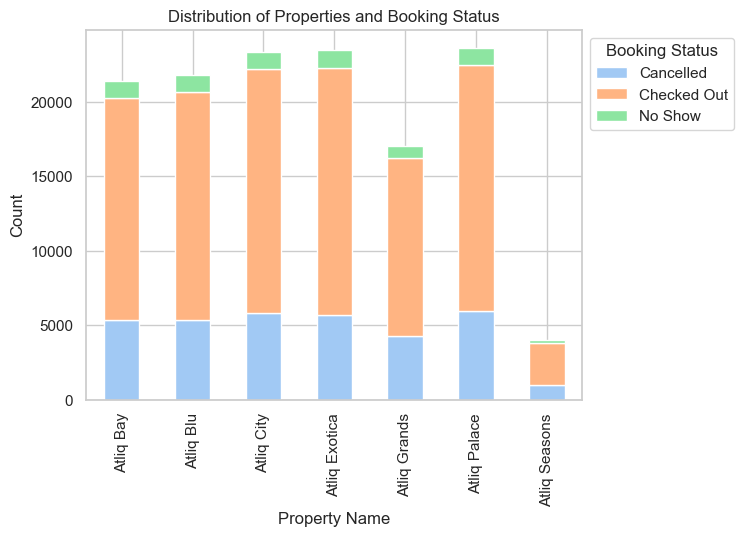

<Figure size 640x480 with 0 Axes>

In [83]:
# Count occurrences of each combination of 'property_name' and 'booking_status'
grouped_counts = data.groupby(['property_name', 'booking_status']).size().unstack(fill_value=0)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot grouped bar chart
grouped_counts.plot(kind='bar', stacked=True)
plt.title('Distribution of Properties and Booking Status')
plt.xlabel('Property Name')
plt.ylabel('Count')
plt.legend(title='Booking Status', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)

plt.show()

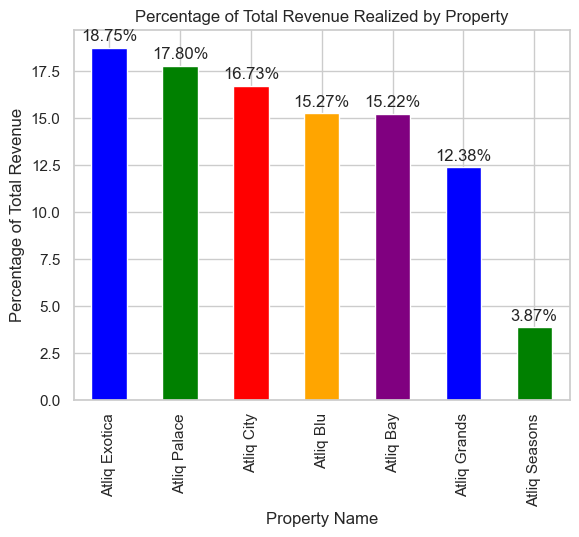

<Figure size 640x480 with 0 Axes>

In [84]:
#Revenue Generated from the Properties
grouped_data = data.groupby("property_name")["revenue_realized"].sum().sort_values(ascending=False)

# Calculate total revenue realized
total_revenue = grouped_data.sum()

# Calculate percentages
percentages = (grouped_data / total_revenue) * 100

# Define colors for bars
colours = ['blue', 'green', 'red', 'orange', 'purple']

# Create the bar chart
ax = percentages.plot(kind="bar", color=colours)

# Add percentages on top of bars
for i, v in enumerate(percentages):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='top')

plt.xlabel('Property Name')
plt.ylabel('Percentage of Total Revenue')
plt.title('Percentage of Total Revenue Realized by Property')
plt.show()

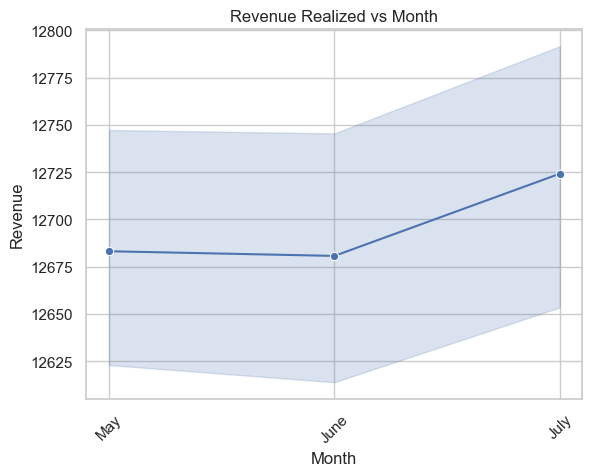

<Figure size 640x480 with 0 Axes>

In [85]:
# Set Seaborn style
sns.set(style="whitegrid")

# Plotting the line chart
sns.lineplot(data=data, x='month', y='revenue_realized', marker='o')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Revenue Realized vs Month')

plt.xticks(rotation=45)

plt.show()

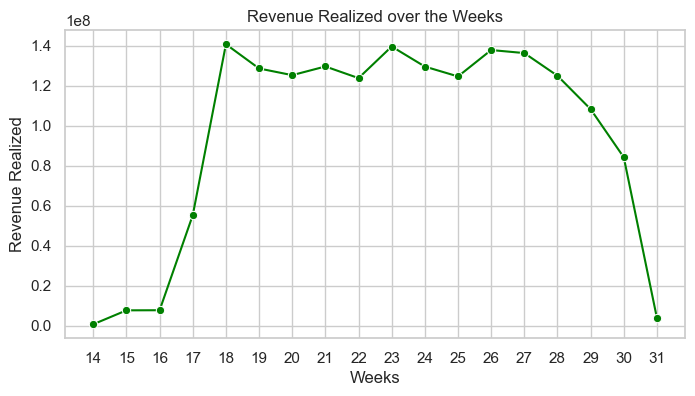

<Figure size 640x480 with 0 Axes>

In [86]:
#Revenue realized over the weeks
grouped = data.groupby("week")["revenue_realized"].sum().reset_index()

plt.figure(figsize=(8,4))
ax = sns.lineplot(x='week', y='revenue_realized', data=grouped, color='green', marker='o')


plt.xlabel('Weeks')
plt.ylabel('Revenue Realized')
plt.title('Revenue Realized over the Weeks')
plt.grid(True)
plt.show()

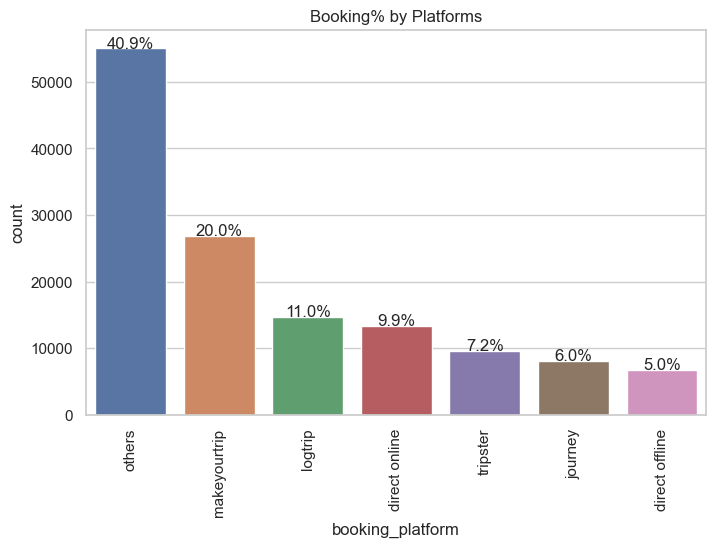

In [61]:
# Get the counts of each booking platform
sorted_df = data["booking_platform"].value_counts().reset_index()

# Plot the countplot
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=data, x="booking_platform", order=sorted_df["booking_platform"])

# Add percentages on top of the bars
total = len(data)  # Total number of observations
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{height / total:.1%}', ha="center")

# Set title and rotate x-axis labels
plt.title("Booking% by Platforms")
plt.xticks(rotation=90)

# Show plot
plt.show()

<Figure size 1000x600 with 0 Axes>

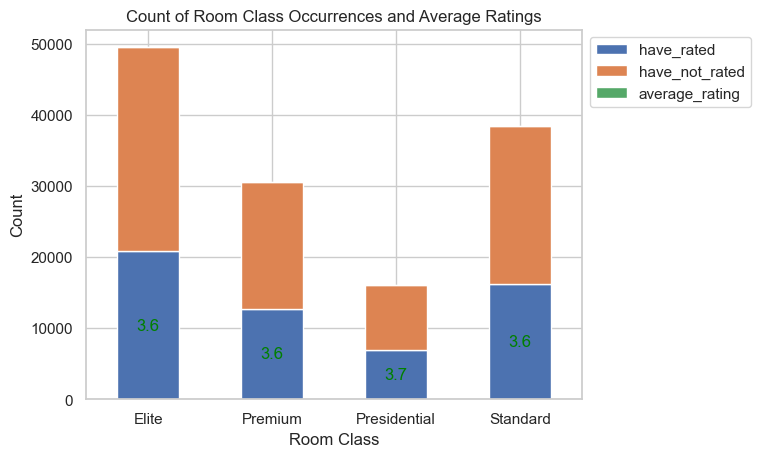

In [62]:
# Count occurrences of room class and average ratings
have_rated = data[data["ratings_given"] != "NONE"].groupby("room_class")["ratings_given"].count().reset_index(name="have_rated")
have_not_rated = data[data["ratings_given"] == "NONE"].groupby("room_class")["ratings_given"].count().reset_index(name="have_not_rated")

# Calculate average ratings for each room class
average_ratings = data[data["ratings_given"] != "NONE"].groupby("room_class")["ratings_given"].mean().reset_index(name="average_rating")

# Merge the two DataFrames
integrated_df = pd.merge(have_rated, have_not_rated, on='room_class', how='left')

# Merge the average_ratings DataFrame with integrated_df
integrated_df = pd.merge(integrated_df, average_ratings, on='room_class', how='left')

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot grouped bar chart
ax = integrated_df.plot(kind='bar', stacked=True)

for index, row in integrated_df.iterrows():
    ax.annotate(f'{row["average_rating"]:.1f}', (index, row["have_rated"] / 2), ha='center', va='center', color='green')


plt.title("Count of Room Class Occurrences and Average Ratings")
plt.xlabel('Room Class')
plt.ylabel('Count')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(range(len(integrated_df)), integrated_df['room_class'], rotation=0)

plt.show()

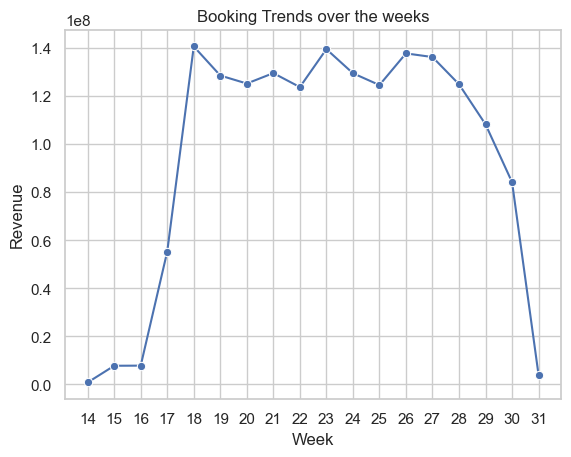

In [63]:
#Booking patterns trends

# Aggregate the data by week
data['week'] = data['booking_date'].dt.strftime('%U')
weekly_revenue = data.groupby('week')['revenue_realized'].sum().reset_index()

# Plotting the trend by week
sns.lineplot(data=weekly_revenue, x='week', y='revenue_realized', marker='o')

# Adding labels and title
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.title('Booking Trends over the weeks')


# Display the plot
plt.show()

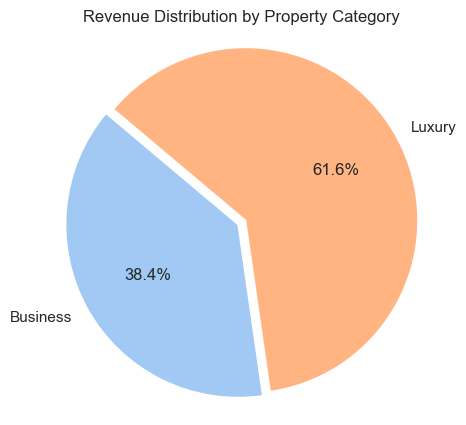

In [64]:
#Property category vs Revenue Realized

# Aggregate the revenue realized by property category
aggregated_data = data.groupby('property_category')['revenue_realized'].sum().reset_index()

# Define the slice to explode
explode = (0, 0.05)

# Plotting the pie chart
plt.figure(figsize=(5, 5))
sns.set_palette("pastel")  # Set color palette
plt.pie(aggregated_data['revenue_realized'], labels=aggregated_data['property_category'],explode=explode ,autopct='%1.1f%%', startangle=140)
plt.title('Revenue Distribution by Property Category')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show plot
plt.show()

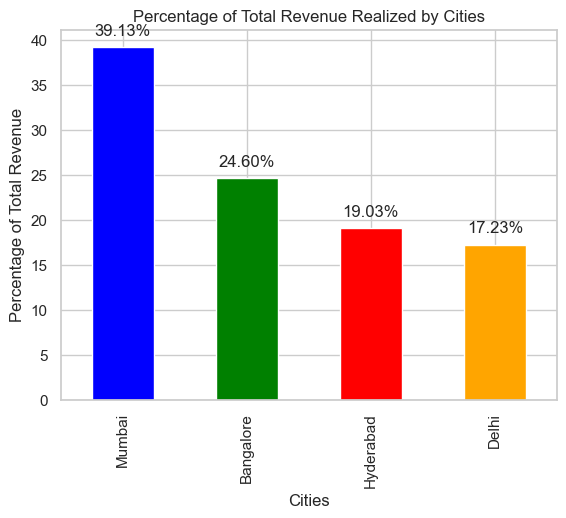

In [65]:
#Revenue realized by cities
grouped = data.groupby("city")["revenue_realized"].sum().sort_values(ascending=False)

percentages = round((grouped / grouped.sum()) * 100, 2)

# Define colors for bars
colours = ['blue', 'green', 'red', 'orange', 'purple']

# Create the bar chart
ax = percentages.plot(kind="bar", color=colours)

# Add percentages on top of bars
for i, v in enumerate(percentages):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')

plt.xlabel('Cities')
plt.ylabel('Percentage of Total Revenue')
plt.title('Percentage of Total Revenue Realized by Cities')
plt.show()

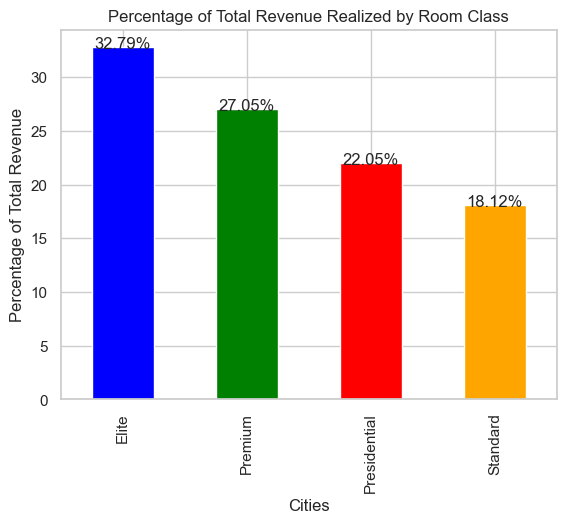

In [66]:
#Revenue realized by room class
grouped = data.groupby("room_class")["revenue_realized"].sum().sort_values(ascending=False)

percentages = round((grouped / grouped.sum()) * 100, 2)

# Define colors for bars
colours = ['blue', 'green', 'red', 'orange', 'purple']

# Create the bar chart
ax = percentages.plot(kind="bar", color=colours)

# Add percentages on top of bars
for i, v in enumerate(percentages):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='top')

plt.xlabel('Cities')
plt.ylabel('Percentage of Total Revenue')
plt.title('Percentage of Total Revenue Realized by Room Class')
plt.show()

In [67]:
#Reading the fact_aggregated_booking file
fact_aggr = pd.read_csv("Dataset/fact_aggregated_bookings.csv")
fact_aggr["check_in_date"] = pd.to_datetime(fact_aggr["check_in_date"])

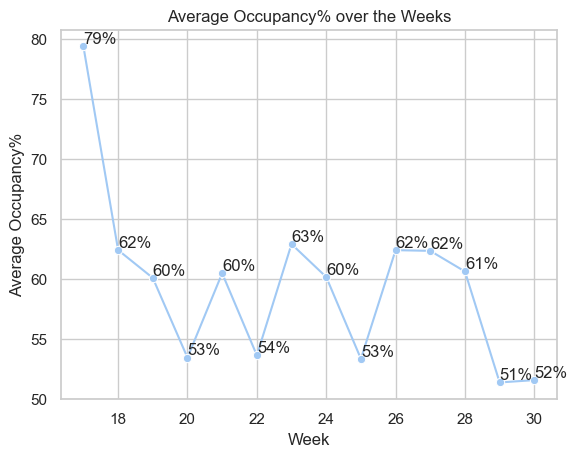

<Figure size 1800x700 with 0 Axes>

In [68]:
#Calculating Occupancy%
fact_aggr["occupancy_perc"] = round((fact_aggr.successful_bookings / fact_aggr.capacity) * 100, 2)

#Adding Column
fact_aggr["week"] = fact_aggr['check_in_date'].dt.strftime('%W')
fact_aggr["week"] = pd.to_numeric(fact_aggr["week"])

# Aggregate the data by week
weekly_occupancy = fact_aggr.groupby('week')['occupancy_perc'].mean().reset_index()

# Plotting the trend by week
sns.lineplot(data=weekly_occupancy, x='week', y='occupancy_perc', marker='o')

# Adding labels and title
plt.xlabel('Week')
plt.ylabel('Average Occupancy%')
plt.title('Average Occupancy% over the Weeks')

# Filter only marker points
marker_points = weekly_occupancy[weekly_occupancy['week'] % 1 == 0]

# Annotating only the marker points with their corresponding value
for index, row in marker_points.iterrows():
    plt.text(row['week'], row['occupancy_perc'], f'{row["occupancy_perc"]:.0f}%', ha='left', va='bottom')

# Display the plot
plt.figure(figsize=(18,7))
plt.show()

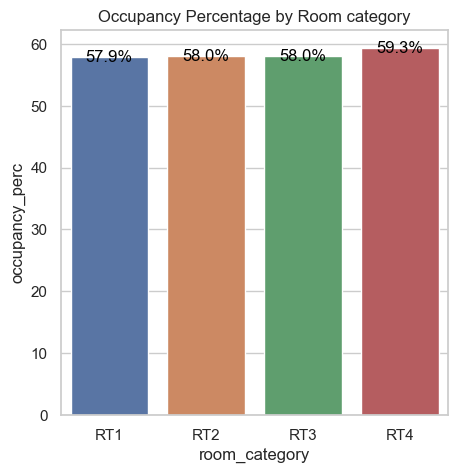

In [70]:
#Occupancy percentage by room_category

# Aggregate the revenue realized by property category
aggregated_data = fact_aggr.groupby('room_category')['occupancy_perc'].mean().reset_index()

# Plotting the bar chart
plt.figure(figsize=(5, 5))
sns.set_palette("deep")  # Set color palette
bar_plot = sns.barplot(data=aggregated_data, x="room_category", y="occupancy_perc", order=aggregated_data.sort_values(by='occupancy_perc')['room_category'])

# Adding numbers on the bars
for index, row in aggregated_data.iterrows():
    bar_plot.text(index, row['occupancy_perc'], f'{row["occupancy_perc"]:.1f}%', color='black', ha="center", va='center')


# Show plot
plt.title("Occupancy Percentage by Room category")
plt.show()

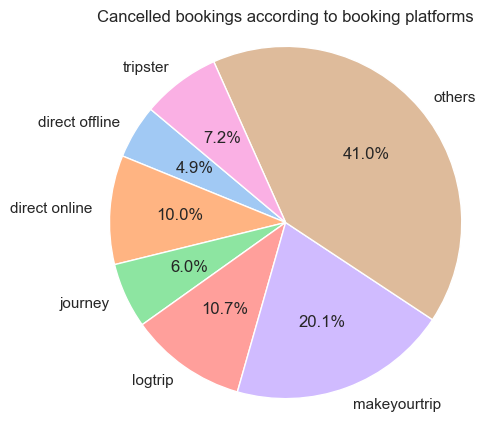

In [71]:
cancelled_bookings_df = data[data["booking_status"] == "Cancelled"]

aggregated_data = cancelled_bookings_df.groupby("booking_platform")["booking_status"].count().reset_index()

# Plotting the pie chart
plt.figure(figsize=(5, 5))
sns.set_palette("pastel")  # Set color palette
plt.pie(aggregated_data['booking_status'], labels=aggregated_data['booking_platform'], autopct='%1.1f%%', startangle=140)
plt.title('Cancelled bookings according to booking platforms')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show plot
plt.show()

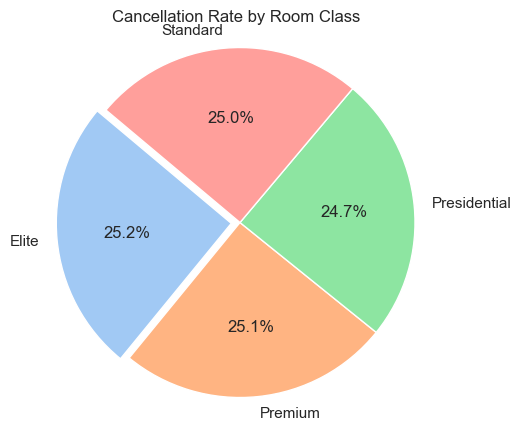

In [72]:
# Calculate total bookings and total cancelled bookings by property category
booking_counts = data.groupby('room_class')['booking_status'].count().reset_index(name='total_bookings')
cancelled_counts = data[data['booking_status'] == 'Cancelled'].groupby('room_class')['booking_status'].count().reset_index(name='total_cancelled')

# Merge the two DataFrames
cancellation_rate = pd.merge(booking_counts, cancelled_counts, on='room_class', how='left')

# Calculate cancellation rate
cancellation_rate['cancellation_rate'] = cancellation_rate['total_cancelled'] / cancellation_rate['total_bookings']

# Plotting the results as a pie chart
plt.figure(figsize=(5, 5))
plt.pie(cancellation_rate['cancellation_rate'], labels=cancellation_rate['room_class'],explode=(0.05, 0,0,0) ,autopct='%1.1f%%', startangle=140)
plt.title('Cancellation Rate by Room Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

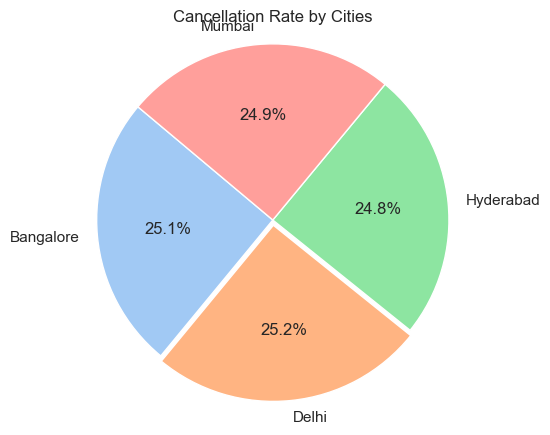

In [73]:
# Calculate total bookings and total cancelled bookings by property category
booking_counts = data.groupby('city')['booking_status'].count().reset_index(name='total_bookings')
cancelled_counts = data[data['booking_status'] == 'Cancelled'].groupby('city')['booking_status'].count().reset_index(name='total_cancelled')

# Merge the two DataFrames
cancellation_rate = pd.merge(booking_counts, cancelled_counts, on='city', how='left')

# Calculate cancellation rate
cancellation_rate['cancellation_rate'] = cancellation_rate['total_cancelled'] / cancellation_rate['total_bookings']

# Plotting the results as a pie chart
plt.figure(figsize=(5, 5))
plt.pie(cancellation_rate['cancellation_rate'], labels=cancellation_rate['city'], explode=(0,0.03,0,0) ,autopct='%1.1f%%', startangle=140)
plt.title('Cancellation Rate by Cities')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

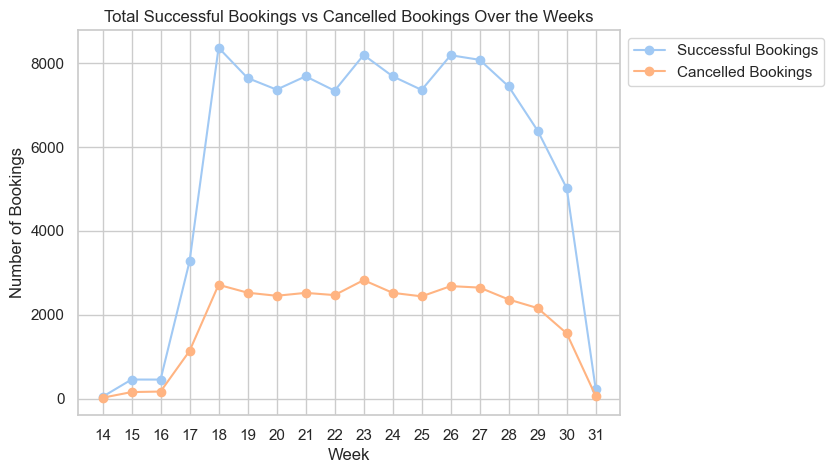

In [74]:
# Calculate total bookings and total cancelled bookings by week
booking_counts = data[data['booking_status'] != 'Cancelled'].groupby('week')['booking_status'].count().reset_index(name='total_succesful_bookings')
cancelled_counts = data[data['booking_status'] == 'Cancelled'].groupby('week')['booking_status'].count().reset_index(name='total_cancelled_bookings')

# Merge the two DataFrames
cancellation_df = pd.merge(booking_counts, cancelled_counts, on='week', how='left')

# Plotting the results as a line chart
plt.figure(figsize=(7, 5))
plt.plot(cancellation_df["week"], cancellation_df["total_succesful_bookings"], label='Successful Bookings', marker='o')
plt.plot(cancellation_df["week"], cancellation_df["total_cancelled_bookings"], label='Cancelled Bookings', marker='o')
plt.xlabel('Week')
plt.ylabel('Number of Bookings')
plt.title('Total Successful Bookings vs Cancelled Bookings Over the Weeks')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## *Metrices*

### Total Revenue Realized

In [75]:
print(f"{round((data.revenue_realized.sum()) / 10000000, 2)} Crores")

170.88 Crores


### Total Bookings

In [76]:
total_bookings = data.booking_id.count()
total_bookings

134590

### Average Rating

In [77]:
round(data[data["ratings_given"] != "NONE"].ratings_given.mean(), 2)

3.62

### Total Capacity

In [78]:
fact_aggr.capacity.sum()

232576

### Total successful Bookings

In [79]:
fact_aggr.successful_bookings.sum()

134590

### Occupancy Percentage

In [80]:
round(fact_aggr.successful_bookings.sum() / fact_aggr.capacity.sum(), 2)

0.58

### Total Cancelled Bookings

In [81]:
cancelled_bookings = data[data["booking_status"] == "Cancelled"].booking_id.count()
cancelled_bookings

33420

### Cancellation Rate

In [82]:
round(cancelled_bookings / total_bookings, 2)

0.25